In [1]:
# Import libraries.
import os
import requests


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)

In [3]:
if not os.path.exists('insurance.csv'):
    url = 'https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv'
    response = requests.get(url)
    with open('insurance.csv', 'wb') as file:
        file.write(response.content)

dataset = pd.read_csv('insurance.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


## Explanatory Analysis

In [3]:
# We have 4 numerical features and 3 categorical features.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
# The minimum age in the dataset is 18 and the maximum age is 64. 
# Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year)
fig = px.histogram(dataset, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

In [13]:
fig = px.histogram(dataset, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

In [17]:
fig = px.histogram(dataset, 
                   x='expenses', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

In [18]:
# An imbalance in the number of smokers and non-smokers in the dataset is observed.
# We will examine if any actions need to be taken to address this.
dataset.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


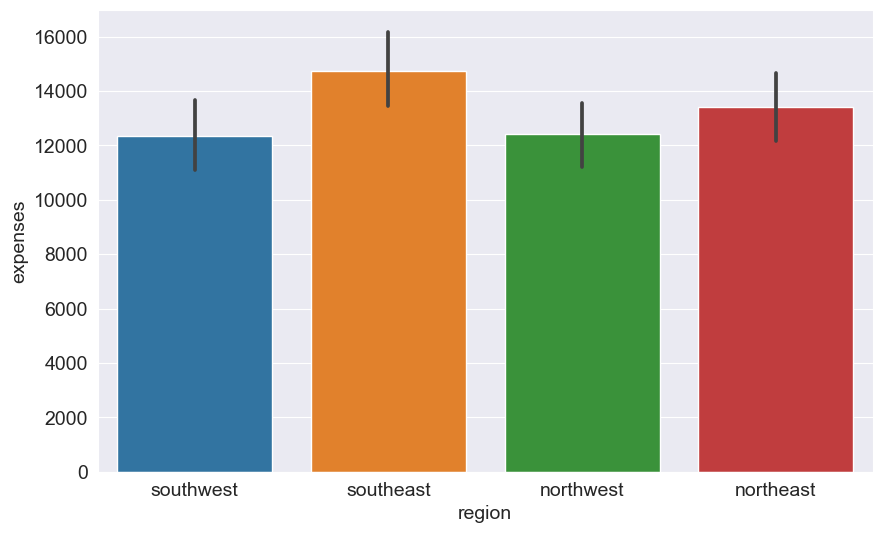

In [9]:
sns.barplot(data=dataset, x='region', y='expenses');

## Preprocessing
* Convert categorical columns into numeric, via One-hot encoding
* Apply the min-max scaler to numerical values to be in range of [0 1]

In [4]:
# Get a list of categorical variables
obj_cols = dataset.select_dtypes('object').columns.tolist()

In [5]:
# Apply one-hot encoding to each column with categorical data
df = dataset.copy()
df = pd.get_dummies(df, columns=obj_cols).astype('int')
df.head()

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,1,0,0,1,0,0,0,1
1,18,33,1,1725,0,1,1,0,0,0,1,0
2,28,33,3,4449,0,1,1,0,0,0,1,0
3,33,22,0,21984,0,1,1,0,0,1,0,0
4,32,28,0,3866,0,1,1,0,0,1,0,0


In [6]:
# Get a list of numerical features, omitting the target
num_cols = dataset.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('expenses')

In [7]:
# Scale the numerical features 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.297297,0.0,16884,1,0,0,1,0,0,0,1
1,0.000000,0.459459,0.2,1725,0,1,1,0,0,0,1,0
2,0.217391,0.459459,0.6,4449,0,1,1,0,0,0,1,0
3,0.326087,0.162162,0.0,21984,0,1,1,0,0,1,0,0
4,0.304348,0.324324,0.0,3866,0,1,1,0,0,1,0,0


In [8]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=0)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Remove the target from features and return it at the assighned variable
train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

### Dense NN implementation

In [9]:
model = keras.Sequential()
model.add(layers.Input(shape=(11,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=100, verbose=2)

Epoch 1/100
27/27 - 1s - loss: 12872.4844 - mae: 12872.4844 - mse: 303991552.0000 - val_loss: 14506.4590 - val_mae: 14506.4590 - val_mse: 371957984.0000 - 558ms/epoch - 21ms/step
Epoch 2/100
27/27 - 0s - loss: 12869.4131 - mae: 12869.4131 - mse: 303907968.0000 - val_loss: 14501.7188 - val_mae: 14501.7188 - val_mse: 371813824.0000 - 42ms/epoch - 2ms/step
Epoch 3/100
27/27 - 0s - loss: 12861.9775 - mae: 12861.9775 - mse: 303711168.0000 - val_loss: 14490.4150 - val_mae: 14490.4150 - val_mse: 371473984.0000 - 42ms/epoch - 2ms/step
Epoch 4/100
27/27 - 0s - loss: 12845.5371 - mae: 12845.5371 - mse: 303263520.0000 - val_loss: 14467.2822 - val_mae: 14467.2822 - val_mse: 370782944.0000 - 42ms/epoch - 2ms/step
Epoch 5/100
27/27 - 0s - loss: 12814.6680 - mae: 12814.6680 - mse: 302450144.0000 - val_loss: 14426.6387 - val_mae: 14426.6387 - val_mse: 369574624.0000 - 42ms/epoch - 2ms/step
Epoch 6/100
27/27 - 0s - loss: 12763.5254 - mae: 12763.5254 - mse: 301135072.0000 - val_loss: 14362.5176 - val_ma

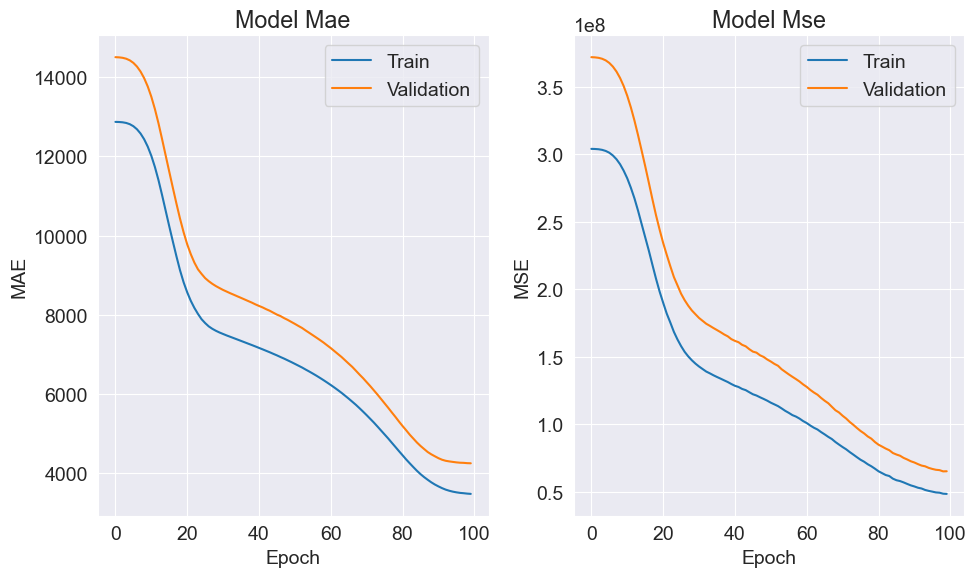

In [10]:
def plot_loss(history, metric='mae'):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend(['Train', 'Validation'], loc='upper right')
    
plt.subplot(1, 2, 1)
plot_loss(history, 'mae')
plt.subplot(1, 2, 2)
plot_loss(history, 'mse')

plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 168us/step


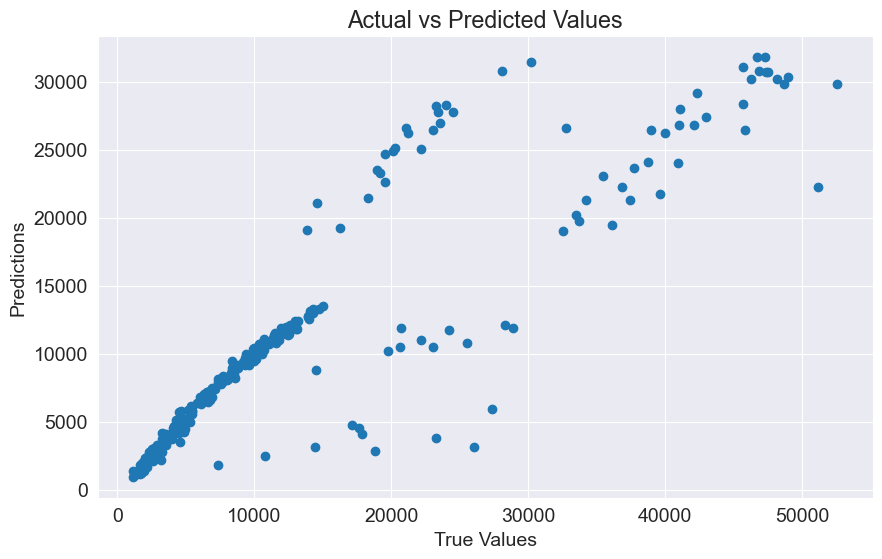

Mean Absolute Error (MAE): 3611.59
Mean Squared Error (MSE): 49144026.66


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Make predictions on the test set
predictions = model.predict(test_features)

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted Values')
plt.show()

# Calculate and print evaluation metrics
mae = mean_absolute_error(test_labels, predictions)
mse = mean_squared_error(test_labels, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')

## Preprocessing (different approach)
* Convert categorical columns into numeric, via Label encoder
* Normalization layer

In [4]:
# Get a list of categorical variables
obj_cols = dataset.select_dtypes('object').columns.tolist()

In [12]:
'''
If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to 
numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals.
# '''
# from sklearn.preprocessing import OrdinalEncoder
# df = dataset.copy()
# oe = OrdinalEncoder()
# df[obj_cols] = oe.fit_transform(df[obj_cols])

# However, in this case, the categories do not have a natural order
from sklearn.preprocessing import LabelEncoder
df = dataset.copy()
le = LabelEncoder()
df['region'] = le.fit_transform(df['region'])
df['sex'] = le.fit_transform(df['sex'])
df['region'] = le.fit_transform(df['region'])
df['smoker'] = le.fit_transform(df['smoker'])

df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [13]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=0)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Removes the target from features and returns it at the assighned variable
train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

### Baseline models using sklearn

In [10]:
# Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_features, train_labels)
pred_labels = model.predict(test_features)

from sklearn import metrics
mae = metrics.mean_absolute_error(test_labels, pred_labels)
mse = metrics.mean_squared_error(test_labels, pred_labels)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Absolute Error (MAE): 3930.22
Mean Squared Error (MSE): 31841055.89


In [11]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0).fit(train_features, train_labels)
pred_labels = model.predict(test_features)

from sklearn import metrics
mae = metrics.mean_absolute_error(test_labels, pred_labels)
mse = metrics.mean_squared_error(test_labels, pred_labels)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Absolute Error (MAE): 2474.73
Mean Squared Error (MSE): 16569842.09


### NN using keras 

In [8]:
'''
In a 2D array axis=1 or axis=-1 can be used interchangeably, since when -1 is selected
the last axis of the input is assumed to be a feature dimension and is normalized per index,
hence column-wise.
'''
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
head = np.array(train_features[:5])

with np.printoptions(precision=2, suppress=True):
  print('First 5 rows:', head)
  print()
  print('Normalized:', normalizer(head).numpy())

First 5 rows: [[37.   1.  34.1  4.   1.   3. ]
 [18.   1.  34.4  0.   0.   2. ]
 [23.   0.  36.7  2.   1.   0. ]
 [32.   1.  35.2  2.   0.   3. ]
 [58.   0.  32.4  1.   0.   0. ]]

Normalized: [[-0.15  1.02  0.54  2.41  1.97  1.31]
 [-1.5   1.02  0.59 -0.89 -0.51  0.4 ]
 [-1.14 -0.99  0.97  0.76  1.97 -1.4 ]
 [-0.5   1.02  0.72  0.76 -0.51  1.31]
 [ 1.34 -0.99  0.27 -0.07 -0.51 -1.4 ]]


In [14]:
train_features.shape[1:]

(6,)

In [16]:
# Neural Network
'''
It is good practice to normalize features that use different scales and ranges.
One reason this is important is because the features are multiplied by the model weights.
So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
'''
normalizer = layers.experimental.preprocessing.Normalization(input_shape=train_features.shape[1:] , axis=-1)
# It can be passed either as a tf.data.Dataset, or as a numpy array.
normalizer.adapt(np.array(train_features))

model = keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=100, verbose=0)

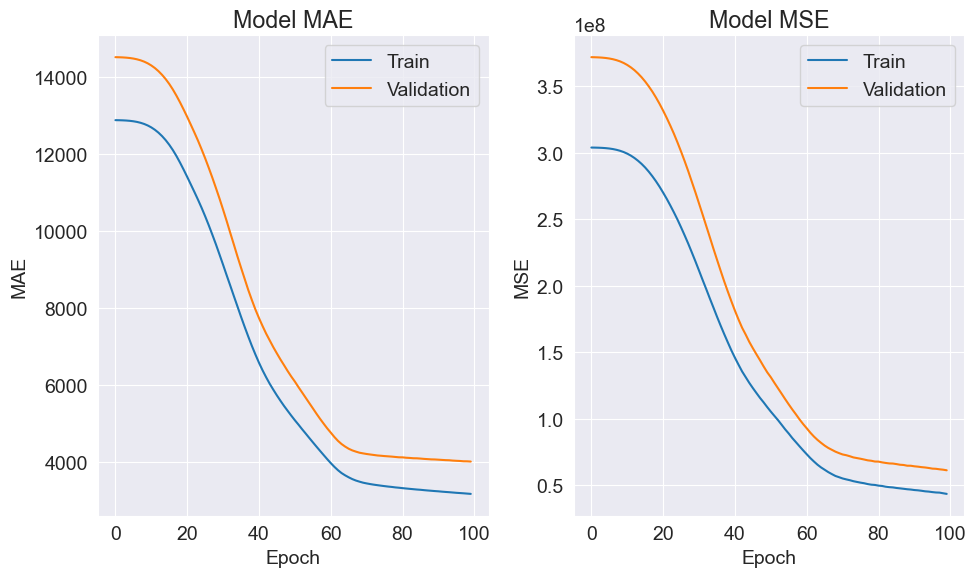

In [17]:

def plot_metric(history, metric='mae'):
    
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(1, 2, 1)
plot_metric(history, 'mae')
plt.subplot(1, 2, 2)
plot_metric(history, 'mse')
plt.tight_layout()
plt.show()

9/9 - 0s - loss: 3244.0825 - mae: 3244.0825 - mse: 42199252.0000 - 18ms/epoch - 2ms/step
Testing set Mean Abs Error: 3244.08 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 778us/step


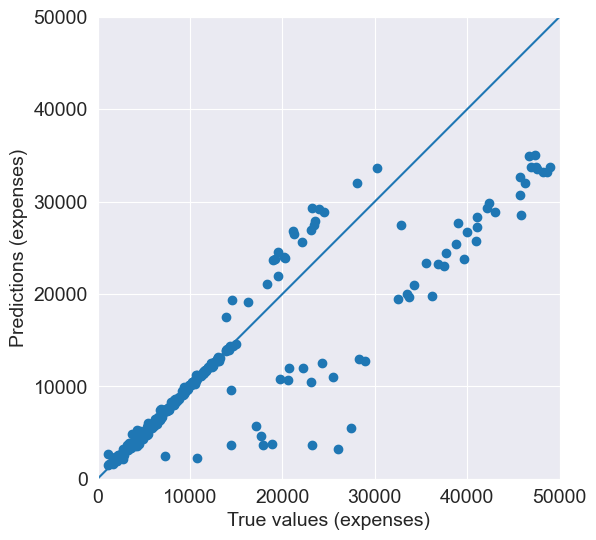

In [18]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.

# loss, mae, mse = linear_model.evaluate(test_features, test_labels, verbose=2)
loss, mae, mse = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
